In [32]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/palm-train-test-val/trainTestVal/validation/0/img0022.jpg
/kaggle/input/palm-train-test-val/trainTestVal/validation/0/img0401.jpg
/kaggle/input/palm-train-test-val/trainTestVal/validation/0/img0176.jpg
/kaggle/input/palm-train-test-val/trainTestVal/validation/0/img0190.jpg
/kaggle/input/palm-train-test-val/trainTestVal/validation/0/img0364.jpg
/kaggle/input/palm-train-test-val/trainTestVal/validation/0/img0171.jpg
/kaggle/input/palm-train-test-val/trainTestVal/validation/0/img0295.jpg
/kaggle/input/palm-train-test-val/trainTestVal/validation/0/img0184.jpg
/kaggle/input/palm-train-test-val/trainTestVal/validation/0/img0145.jpg
/kaggle/input/palm-train-test-val/trainTestVal/validation/0/img0424.jpg
/kaggle/input/palm-train-test-val/trainTestVal/validation/0/img0492.jpg
/kaggle/input/palm-train-test-val/trainTestVal/validation/0/img0311.jpg
/kaggle/input/palm-train-test-val/trainTestVal/validation/0/img0029.jpg
/kaggle/input/palm-train-test-val/trainTestVal/validation/0/img0

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Input, Lambda, concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from keras.utils import to_categorical
from keras.layers import Input
from tensorflow.keras.models import load_model
from keras.callbacks import ModelCheckpoint

In [3]:
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
import os
import random
import numpy as np

In [4]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print('Num GPUs Available: ', len(physical_devices))
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


In [5]:
M = 408
N = 306

batch_sz = 16
num_epochs = 48

In [6]:
train_path = '/kaggle/input/palm-train-test-val/trainTestVal/train'
val_path = '/kaggle/input/palm-train-test-val/trainTestVal/validation'
test_path = '/kaggle/input/palm-train-test-val/trainTestVal/test'
classNames = ['no_match', 'match']


In [8]:
# generates pairs of template + matching image and template + non-matching image
def generate_pairs(directory, shuffle=True):
    template_folder = os.path.join(directory, 't')
    pos_folder = os.path.join(directory, '1')
    neg_folder = os.path.join(directory, '0')

    num_images = len(os.listdir(template_folder))

    # Generate positive pairs
    pos_pairs = []
    template_idx = 0
    for i in range(num_images):
        template_idx += 1
        pos_idx = template_idx  # Use the same index for template and positive image
        template_file = os.path.join(template_folder, 'img{:04d}.jpg'.format(template_idx))
        pos_file = os.path.join(pos_folder, 'img{:04d}.jpg'.format(pos_idx))
        pos_pairs.append([template_file, pos_file, 1])
    # Generate negative pairs
    neg_pairs = []
    template_idx = 0
    for i in range(num_images):
        template_idx += 1
        neg_idx = template_idx  # Use the same index for template and neg image
        template_file = os.path.join(template_folder, 'img{:04d}.jpg'.format(template_idx))
        neg_file = os.path.join(neg_folder, 'img{:04d}.jpg'.format(neg_idx))
        neg_pairs.append([template_file, neg_file, 0])

    all_pairs = pos_pairs + neg_pairs
    if shuffle:
        random.shuffle(all_pairs)

    return all_pairs

In [9]:
# splits images and target value
def separateList(dataset_list):
    dataset_pairs = [[lst[0], lst[1]] for lst in dataset_list]
    dataset_labels = [lst[2] for lst in dataset_list]
    return dataset_pairs, dataset_labels

In [10]:
# function to load and preprocess images
def load_and_preprocess_image(image_path, mean_rgb):
    # load image from file path
    image = tf.io.read_file(image_path)
    # decode jpeg encoded image
    image = tf.image.decode_jpeg(image, channels=3)
    # normalize pixel values to be in the range [0, 1] and subtract r,g,b mean
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.subtract(image, mean_rgb)
    return image

In [11]:
# confusion matrix generation
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalizes Confusion Matrix")
    else:
        print("Confusion Matrix, without normalization")
    print(cm)
    thresh = cm.max()/2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [12]:
#get mean RGB for preprocessing
mean_rgb_file = 'mean_rgb_val.csv'
if os.path.isfile(mean_rgb_file):
    mean_rgb = pd.read_csv(mean_rgb_file)
    mean_rgb = np.array(mean_rgb)
else:
    print(f'Error: CSV file "{mean_rgb_file}" not found.')
    mean_rgb = np.array([0.641855879, 0.523251229, 0.51696453])  # load default

Error: CSV file "mean_rgb_val.csv" not found.


In [13]:
# generate image pairs and labels for train, val and test. Test and Val sets are shuffled
train_set = generate_pairs(train_path)
val_set = generate_pairs(val_path)
test_set = generate_pairs(test_path, False)

train_pairs, train_labels = separateList(train_set)
val_pairs, val_labels = separateList(val_set)
test_pairs, test_labels = separateList(test_set)

train_labels = np.array(train_labels)
val_labels = np.array(val_labels)
test_labels = np.array(test_labels)

In [14]:
# create training dataset from pairs and labels
train_dataset = tf.data.Dataset.from_tensor_slices((train_pairs, train_labels))
#map image loading and preprocessing function to the training pairs
train_dataset = train_dataset.map(lambda x, y: ((load_and_preprocess_image(x[0], mean_rgb), load_and_preprocess_image(x[1], mean_rgb)), y))
# batch the training dataset
train_dataset = train_dataset.batch(batch_sz)


In [28]:
# create validation dataset from pairs and labels
val_dataset = tf.data.Dataset.from_tensor_slices((val_pairs, val_labels))
# map image loading and preprocessing function to the validation pairs
val_dataset = val_dataset.map(lambda x, y: ((load_and_preprocess_image(x[0], mean_rgb), load_and_preprocess_image(x[1], mean_rgb)), y))
# batch the validation dataset
val_dataset = val_dataset.batch(batch_sz)

In [15]:
# create validation dataset from pairs and labels
test_dataset = tf.data.Dataset.from_tensor_slices((test_pairs, test_labels))
# map image loading and preprocessing function to the validation pairs
test_dataset = test_dataset.map(lambda x, y: ((load_and_preprocess_image(x[0], mean_rgb), load_and_preprocess_image(x[1], mean_rgb)), y))
test_dataset = test_dataset.batch(16)

In [16]:
input_shape = (M, N, 3)
template_input = Input(input_shape)
test_input = Input(input_shape)

In [17]:
# left and right twin branches of the network
convnet = Sequential([
    Conv2D(8, (23, 23), activation='relu', input_shape=input_shape),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(16, (13, 13), activation='relu'),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(32, (7, 7), activation='relu'),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(48, (5, 5), activation='relu'),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D(pool_size=(2, 2), strides=1),
    Conv2D(96, (3, 3), activation='relu'),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D(pool_size=(2, 2), strides=1),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    Activation('relu'),
    Flatten(),
])

In [18]:
print("convnet summary:")
convnet.summary()

convnet summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 386, 284, 8)       12704     
                                                                 
 batch_normalization (BatchN  (None, 386, 284, 8)      32        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 386, 284, 8)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 193, 142, 8)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 181, 130, 16)      21648     
                                                                 
 batch_normalization_1 (Batc  (None, 18

In [19]:
encoded_l = convnet(template_input)
encoded_r = convnet(test_input)

In [20]:
# merged part of the network
merged = concatenate([encoded_l, encoded_r])
merged = Dense(512, activation='relu')(merged)
merged = Dropout(0.15)(merged)
merged = Dense(128, activation='relu')(merged)
merged = Dropout(0.15)(merged)
prediction = Dense(1, activation='sigmoid')(merged)

In [21]:
siamese_model = Model(inputs=[template_input, test_input], outputs=prediction)

In [22]:
siamese_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.005), metrics=['accuracy'])

In [23]:
print("siamese summary:")
siamese_model.summary()

siamese summary:
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 408, 306, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 408, 306, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 5632)         293312      ['input_1[0][0]',                
                                                                  'input_2[0]

In [24]:
checkpoint_filepath = './models/model_checkpoint.h5'
os.makedirs('./models', exist_ok=True)

In [25]:
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [26]:
# continue training from last checkpoint if the model was trained earlier
if os.path.isfile('./models/model_checkpoint.h5'):
    siamese_model = load_model('./models/model_checkpoint.h5')

In [29]:
siamese_model.fit(x=train_dataset, validation_data=val_dataset, batch_size=batch_sz, epochs=num_epochs, callbacks=[model_checkpoint_callback])

Epoch 1/48
345/345 [==============================] - 97s 236ms/step - loss: 1.0151 - accuracy: 0.5879 - val_loss: 0.5900 - val_accuracy: 0.6748
Epoch 2/48
345/345 [==============================] - 77s 224ms/step - loss: 0.6136 - accuracy: 0.6710 - val_loss: 0.6018 - val_accuracy: 0.7355
Epoch 3/48
345/345 [==============================] - 81s 235ms/step - loss: 0.6027 - accuracy: 0.6774 - val_loss: 0.5006 - val_accuracy: 0.7364
Epoch 4/48
345/345 [==============================] - 78s 225ms/step - loss: 0.5417 - accuracy: 0.7373 - val_loss: 0.4667 - val_accuracy: 0.7754
Epoch 5/48
345/345 [==============================] - 78s 226ms/step - loss: 0.5264 - accuracy: 0.7442 - val_loss: 0.5232 - val_accuracy: 0.7491
Epoch 6/48
345/345 [==============================] - 81s 235ms/step - loss: 0.4871 - accuracy: 0.7786 - val_loss: 0.5219 - val_accuracy: 0.8016
Epoch 7/48
345/345 [==============================] - 78s 225ms/step - loss: 0.4411 - accuracy: 0.8063 - val_loss: 0.3914 - val_ac

In [30]:
predictions = siamese_model.predict(x=test_dataset)
rounded_predictions = np.floor(predictions + 0.5).astype(int)

35/35 [==============================] - 6s 146ms/step


Confusion Matrix, without normalization
[[266  10]
 [  5 271]]


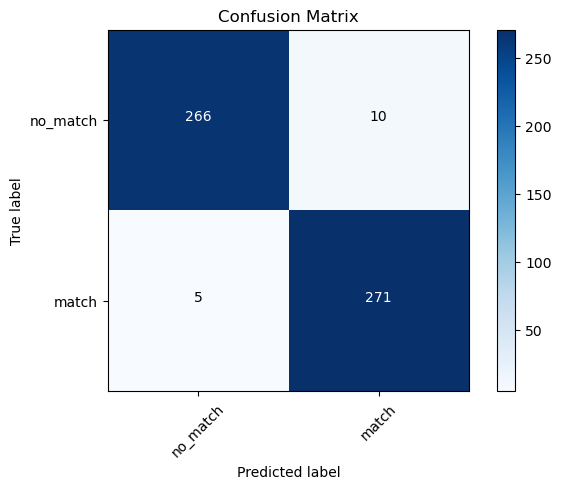

In [31]:
cm = confusion_matrix(y_true=test_labels, y_pred=rounded_predictions)
cm_plot_labels = ['no_match', 'match']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [32]:
print("Test Accuracy = ")
print(np.sum(test_labels == rounded_predictions.reshape(1, len(rounded_predictions)))/len(test_labels))

Test Accuracy = 
0.9728260869565217
